## K-Nearest Neighbors Classification

k-Nearest Neighbors algorithm is a simple, easy to implement supervised machine learning algorithm that can be used for both classification  and regression problems.
kNN algorithm uses ‘feature similarity’ to predict the values of new datapoints which further means that the new data point will be assigned a value based on how closely it matches the points in the training set. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import copy
from math import sqrt
np.random.seed(35819)

In [2]:
def csv_to_nparr(file_name: str):
    csv_content = pd.read_csv('glass.csv')
    print(csv_content)
    return np.array(csv_content)


For kNN algorithm, if one of the variables is in the range of 1000's and another is in the range of 0.1's, the first variable would dominate the distance quite significantly. Therefore we're normalizing the values by transforming them to the range of [0,1].

In [3]:
def normalize_dataset(datalist: np.array):
    for i in range(np.size(datalist, 1) - 1):
        datalist[:,i] = (datalist[:,i] - datalist[:,i].min()) / (datalist[:,i].max() - datalist[:,i].min())

We're using euclidean distance for calculating distance between neighbors.

In [4]:
def calc_distance(firstRow, secondRow):
    sum = 0
    for i in range(len(firstRow)-1):
        sum += (firstRow[i]-secondRow[i])**2
    return sqrt(sum)

## Glass Material Classification

At the first step, we need to prepare our dataset for training and testing. First, we're shuffling and normalizing our dataset. Later on, we will split our dataset according to 5-fold cross validation.

In [5]:
#Preparing data for 5-fold cross validation
data_arr = csv_to_nparr("glass.csv")
np.random.shuffle(data_arr)
non_nm_data_arr = data_arr.copy() # we're using it later

          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  Type
0    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0     1
1    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0     1
2    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0     1
3    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0     1
4    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0     1
..       ...    ...   ...   ...    ...   ...   ...   ...  ...   ...
209  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0     7
210  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0     7
211  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0     7
212  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0     7
213  1.51711  14.23  0.00  2.08  73.36  0.00  8.62  1.67  0.0     7

[214 rows x 10 columns]


In [6]:
normalize_dataset(data_arr)
print(data_arr)

[[0.31474978 0.39097744 0.74387528 ... 0.         0.         3.        ]
 [0.34679543 0.43157895 0.80623608 ... 0.         0.         1.        ]
 [0.44161545 0.4962406  0.83741648 ... 0.         0.         3.        ]
 ...
 [0.30070237 0.4481203  0.8752784  ... 0.         0.29411765 2.        ]
 [0.32309043 0.37142857 0.80846325 ... 0.02857143 0.33333333 2.        ]
 [0.25987709 0.41353383 0.77505568 ... 0.         0.         2.        ]]


Now, we're going to visualize two features at our dataset to show how kNN works. We're choosing RI and Na attributes for this visualization. As we can see from this graph, there is an obvious clustering of same colored points at several places in the plot. 

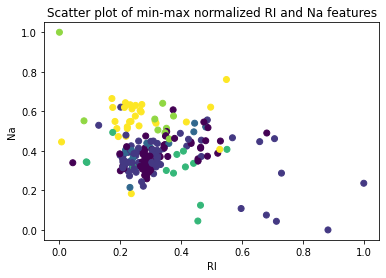

In [7]:
plt.scatter(x=data_arr[:,0],
            y=data_arr[:,1],
            c=data_arr[:, -1])
plt.xlabel("RI")
plt.ylabel("Na")
plt.title("Scatter plot of min-max normalized RI and Na features")
plt.show()

Implementing our non-weighted and weighted kNN functions. Non-weighted one returns the most frequent class value among the k-nearest neighbors. Weighted one sums up the inverse of the distances of the same classes so that closest neighbors will have greater weight.

In [8]:
def kNN(test, trainingdata, k):
    column = [calc_distance(row,test) for row in trainingdata] #adding all distances to a list
    trainingdata = np.column_stack((trainingdata, column)) #adding this list to training data as a column
    trainingdata = trainingdata[np.argsort(trainingdata[:, -1])] #sorting the training data by distance
    nearestNeighbors = []
    for i in range(k):
        nearestNeighbors.append(copy.copy(trainingdata[i])) #getting k nearest neighbors
    trainingdata = np.delete(trainingdata, 0, -1) #converting the training data into its old version
    return nearestNeighbors

In [9]:
def predict(test, trainingdata, k):
    neighbors = kNN(test, trainingdata, k)
    output = [row[-2] for row in neighbors] #adding predictions into a list
    return max(set(output), key=output.count) #returning the most predicted value

In [10]:
def predictWeighted(test, trainingdata, k):
    neighbors = kNN(test, trainingdata, k)
    weights = {}
    for row in neighbors:
        if row[-2] in weights:
            weights[row[-2]] += 1/row[-1] if row[-1] != 0 else 0 #adding all predictions into a dictionary  
        else:                                                    #and summing the same classes' weights up 
            weights[row[-2]] = 1/row[-1] if row[-1] != 0 else 0
    return max(weights, key=lambda key: weights[key]) #returning the class with the highest weight

In [ ]:
def accuracy(weighted, tests, train, k):
        accurate = 0
        for test in tests:
            if weighted:
                if predictWeighted(test, train, k) == test[len(test)-1]: #comparing the predicted value and real value
                    accurate += 1
            else:
                if predict(test, train, k) == test[len(test)-1]:
                    accurate += 1
        return ((accurate/len(tests))*100)

For our 5 fold cross validation algorithm, our test data's length is going to be the one fifth of the total data and the interval is going to change each time. And our training data is going to be the concatenation of total data's starting point to test data's starting point and test data's ending point to total data's ending point. We're going to test this 5 test set according to the 5 training set and take the average of their accuracy values.

In [12]:
def kfold(datalist, k: int, weighted=False):
    j = len(datalist) // 5
    sum = 0
    for i in range(5):
        train = np.concatenate((datalist[:i*j,:],datalist[i*j+j:,:]), axis=0) 
        tests = datalist[i * j: i * j + j, :]
        sum += accuracy(weighted, tests, train, k)
    return sum/5

We've implemented the functions for kNN and 5-fold cross validation. Now, it's time to determine the most optimal k value for our kNN algorithm. First, we want to observe how the kNN accuracy grows by k values. We're visualizing the accuracy for all k values from 1 to 50.

In [13]:
accuracy_values = np.empty((50,))
x_axis_values = np.arange(1, 51)

for kval in range(1, 51):
    accuracy_values[kval-1] = kfold(data_arr, kval)

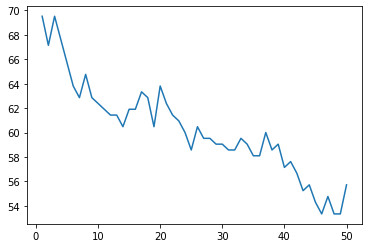

In [14]:
plt.plot(x_axis_values, accuracy_values)
plt.show()

According to the plot the best choice for the k value is between 1 and 10, and we won't use any even k-number for eliminating the risk of vote tie during the process of computing kNN algorithm.

In [15]:
accuracy_values = np.empty((5,))
x_axis_values = np.arange(1, 10, 2)

for i, kval in enumerate(range(1, 10, 2)):
    accuracy_values[i] = kfold(data_arr, kval)

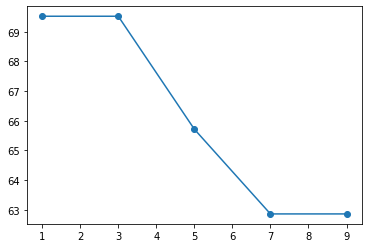

In [16]:
plt.plot(x_axis_values, accuracy_values, marker="o")
plt.show()

By looking at the plot, we can clearly see 1 and 3 are the best choices for our k value. Now, let's calculate it for the weighted kNN algorithm.

In [17]:
accuracy_values = np.empty((5,))
x_axis_values = np.arange(1, 10, 2)

for i, kval in enumerate(range(1, 10, 2)):
    accuracy_values[i] = kfold(data_arr, kval, weighted=True)

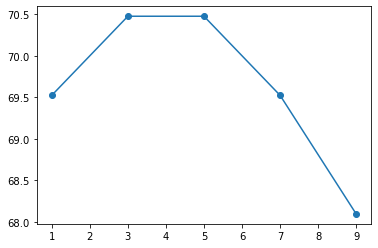

In [18]:
plt.plot(x_axis_values, accuracy_values, marker="o")
plt.show()

We have a different plotting this time and the optimal k values are 3 and 5. As the k value increases, accuracy is decreasing.

## Error Analysis for Classification


Now, we'll see how important normalization is. We're going to try to make a prediction by using normalized and non-normalized datasets and compare them.

In [19]:
print(kfold(data_arr, 3))

69.52380952380952


In [20]:
print(kfold(non_nm_data_arr, 3))

66.66666666666667


We can see how kNN is affected by normalization. The accuracy rate had decreased from 69% to 66% Now, we're comparing non-weighted kNN with weighted kNN.

In [21]:
print(kfold(data_arr, 3, weighted=True))
print(kfold(non_nm_data_arr, 3, weighted=True))

70.47619047619048
69.04761904761904


 It seems that weighted kNN worked better for both our test sets. We can come to the conclusion that giving more importance to the nearer neighbors is a better choice for the classification problem. 